<a href="https://colab.research.google.com/github/dfedeoli/btc2020/blob/main/notebook_btc6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MARATONA BEHIND THE CODE 2020

## DESAFIO 6 - LIT

O LIT faz personalização do ensino com o "Paul", o primeiro tutor do mundo a utilizar a tecnologia de Inteligência Artificial IBM Watson para potencializar a aprendizagem e também a personalização, visando ajudar o aluno a estudar da forma mais adequada para absorver o máximo de conteúdo possível sem desfocar do que ele realmente deve aprender, eliminando assim conteúdos que o aluno já sabe.

Nesse Desafio de Segmentação de Mercado, os participantes deverão dividir por segmentos comportamentais e por competências os alunos do LIT, para gerar uma experiência na plataforma ainda mais personalizada.

Para tanto, neste desafio deverá ser desenvolvido uma solução tecnológica para segmentar os alunos por comportamento e competências.

Do ponto de vista comportamental, os alunos deverão ser divididos em 6 grupos a partir da interação do aluno ao longo de sua jornada no LIT. Cada perfil busca medir o grau de esforço do aluno dentro do progama educacional e qual a melhor jornada para o estudante.

Com a introdução de um novo processo de onboarding na plataforma, teemos a oportunidade de utilizar os dados preenchidos pelos alunos para fazer uma melhor recomendação de quais dos mais 150 cursos do LIT, o aluno deveria se matricular, focando em seus interesses e responsabilidades.

Sendo assim, esperamos poder indicar para cada aluno do LIT quais são os cursos ideais para ele, de acordo com as competências que eles precisam desenvolver para a sua carreira. Esperamos também durante a sua jornada de aprendizagem no LIT, gerar ações de engajamento de acordo com sua atividade na plataforma.

Neste desafio, é necessário criar um modelo de aprendizado de máquina capaz de, com base nas variáveis fornecidas no dataset, identificar o que define o perfil de cada aluno para poder realizar previsões sobre futuros alunos.

Proposição completa do Desafio: https://github.com/maratonadev-br/desafio-6-2020

<hr>

## Importando pacotes importantes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix

## Download dos conjuntos de dados em formato .csv

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/training_dataset.csv
df_training_dataset = pd.read_csv(r'training_dataset.csv')
df_training_dataset.tail()

--2021-03-02 20:15:45--  https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/training_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1736600 (1.7M) [text/plain]
Saving to: ‘training_dataset.csv’

training_dataset.cs 100%[===================>]   1.66M  --.-KB/s    in 0.06s   

2021-03-02 20:15:46 (27.4 MB/s) - ‘training_dataset.csv’ saved [1736600/1736600]



,id,graduacao,universidade,profissao,organizacao,pretende_fazer_cursos_lit,interesse_mba_lit,importante_ter_certificado,horas_semanais_estudo,como_conheceu_lit,total_modulos,modulos_iniciados,modulos_finalizados,certificados,categoria
15852,620397030.0,Bacharelado,UFF,Outros,Borracha,0.0,0.0,1.0,8.0,NaN,10.0,NaN,NaN,NaN,perfil6
15853,229931283.0,Bacharelado,NaN,Advogado,NaN,0.0,0.0,1.0,7.0,Linkedin,42.0,17.0,15.0,NaN,perfil5
15854,480674907.0,Tecnólogo,UNIP,Sócio/Dono/Proprietário,NaN,0.0,NaN,1.0,7.0,Outros,30.0,9.0,8.0,0.0,perfil5
15855,559626807.0,SEM FORMAÇÃO,UNIVERSIDADE NOVE DE JULHO,Advogado,Estado,0.0,0.0,1.0,10.0,NaN,226.0,102.0,93.0,1.0,perfil1
15856,743652801.0,NaN,FGV-RJ,NaN,Siderurgica,1.0,1.0,1.0,9.0,Outros,125.0,98.0,97.0,1.0,perfil1


Sobre o arquivo "training_dataset.csv", temos algumas informações gerais sobre os usuários da plataforma:

**id**: número de matrícula/identificação do estudante;

**graduacao**: Nível de formação do estudante;

**universidade**: Local de formação;

**profissao**: profissão do estudante do LIT;

**organizacao**: Área de atuação;

**pretende_fazer_cursos_lit**: se pretende fazer cursos do LIT;

**interesse_mba_lit**: se tem interesse em fazer um MBA no LIT;

**importante_ter_certificado**: se o aluno acha importante ter certificado;

**horas_semanais_estudo**: horas semanais de estudo do aluno;

**como_conheceu_lit**: por qual plataforma ou mídia conheceu o LIT;

**total_modulos**: total de módulos do estudante;

**modulos_iniciados**: módulos iniciados pelo estudante;

**modulos_finalizados**: módulos finalizados pelo estudante;

**certificados**: se possui ou não certificado;

**categoria**: perfil do estudante.

In [ ]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15857 entries, 0 to 15856
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          13945 non-null  float64
 1   graduacao                   13950 non-null  object 
 2   universidade                13920 non-null  object 
 3   profissao                   13977 non-null  object 
 4   organizacao                 13961 non-null  object 
 5   pretende_fazer_cursos_lit   13989 non-null  float64
 6   interesse_mba_lit           14003 non-null  float64
 7   importante_ter_certificado  13918 non-null  float64
 8   horas_semanais_estudo       13959 non-null  float64
 9   como_conheceu_lit           13915 non-null  object 
 10  total_modulos               13987 non-null  float64
 11  modulos_iniciados           14044 non-null  float64
 12  modulos_finalizados         13924 non-null  float64
 13  certificados                139

In [ ]:
df_training_dataset.nunique()

id                            13945
graduacao                         6
universidade                     21
profissao                        12
organizacao                      11
pretende_fazer_cursos_lit         2
interesse_mba_lit                 2
importante_ter_certificado        1
horas_semanais_estudo             9
como_conheceu_lit                 9
total_modulos                   578
modulos_iniciados               372
modulos_finalizados             339
certificados                     23
categoria                         6
dtype: int64

Como a variável ``importante_ter_certificado`` possui apenas uma resposta (1.0), esta coluna será desde já removida.

In [ ]:
df_training_dataset_1 = df_training_dataset.drop(['importante_ter_certificado'], axis=1)

<hr>

## Detalhamento do desafio: classificação multiclasse

Este é um desafio cujo objetivo de negócio é a segmentação dos usuários de uma plataforma de ensino. Para tal, podemos utilizar duas abordagens: aprendizado de máquina supervisionado (classificação) ou não-supervisionado (clustering). Neste desafio será aplicada a classificação, pois é disponível um dataset já com "labels", ou em outras palavras, já com exemplos de dados juntamente com a variável alvo.

Na biblioteca scikit-learn temos diversos algoritmos para classificação. O participante é livre para utilizar o framework que desejar para completar esse desafio.

A coluna-alvo neste desafio é a coluna ``categoria``.

<hr>

## Pré-processando o dataset antes do treinamento

### Eliminando colunas indesejadas

Vamos **demonstrar** abaixo como usar o método **DataFrame.drop()**.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

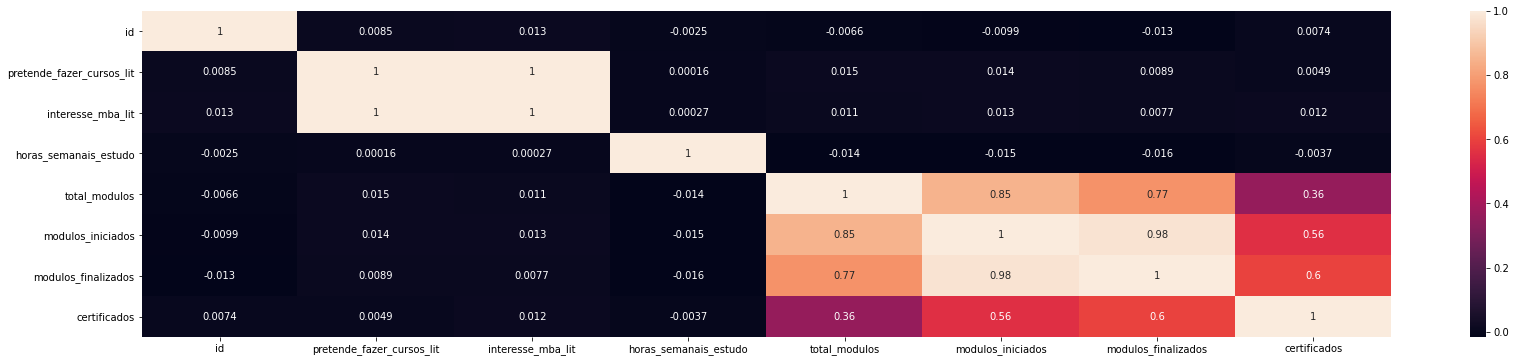

In [ ]:
plt.figure(figsize=(28, 6))
corrMatrix = df_training_dataset_1.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

De acordo com a matriz de correlação, as variáveis ``pretende_fazer_cursos_lit`` e ``interesse_mba_lit`` tem completa relação entre si, assim como possuem alta correlação as variáveis: ``total_modulos``, ``modulos_iniciados`` e ``modulos_finalizados``. Por este motivo, são removidas algumas destas colunas redundantes. Percebe-se também que a coluna ``id`` é própria de cada aluno, não interferindo em seus perfis.

Analisando as colunas de variáveis do tipo *string* e o próposito da plataforma LIT, é possível concluir que alguma destas colunas não fazem, necessariamente, diferença no perfil do aluno. Por ser uma plataforma focada em cursos online e MBA, as profissões dos alunos deve influenciar em seus perfis, visto que a busca pelo LIT provavelmente possui foco profissional e não-acadêmico.

Foram testadas várias combinações de colunas categóricas para a determinação do modelo de aprendizado de máquina, mas o dataset final utilizado só utilizou a coluna ``profissao``.

In [ ]:
df1 = df_training_dataset_1.drop(['id',
               'graduacao',
               'universidade',
               'organizacao',
               'modulos_iniciados',
               'pretende_fazer_cursos_lit',
               'total_modulos',
               'como_conheceu_lit'], axis=1)
df1.head()

,profissao,interesse_mba_lit,horas_semanais_estudo,modulos_finalizados,certificados,categoria
0,Analista Senior,1.0,6.0,4.0,0.0,perfil6
1,Supervisor,0.0,6.0,34.0,0.0,perfil2
2,Outros,1.0,10.0,27.0,0.0,perfil2
3,Outros,1.0,5.0,6.0,0.0,perfil5
4,SEM EXPERIÊNCIA,0.0,7.0,44.0,0.0,perfil2


### Removendo todas as linhas que possuem algum valor nulos em determinadas colunas

Usando o método Pandas **DataFrame.dropna()** você pode remover todas as linhas nulas do dataset.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [ ]:
# Exibindo os dados ausentes do conjunto de dados antes da primeira transformação (df)
print("Valores nulos no df_training_dataset antes da transformação DropNA: \n\n{}\n".format(df1.isnull().sum(axis = 0)))

Valores nulos no df_training_dataset antes da transformação DropNA: 

profissao                1880
interesse_mba_lit        1854
horas_semanais_estudo    1898
modulos_finalizados      1933
certificados             1878
categoria                   0
dtype: int64



In [ ]:
df2 = df1.dropna()

In [ ]:
# Exibindo os dados ausentes do conjunto de dados após a primeira transformação (df)
print("Valores nulos no df_training_dataset após a transformação DropNA: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

Valores nulos no df_training_dataset após a transformação DropNA: 

profissao                0
interesse_mba_lit        0
horas_semanais_estudo    0
modulos_finalizados      0
certificados             0
categoria                0
dtype: int64



In [ ]:
df2.head()

,profissao,interesse_mba_lit,horas_semanais_estudo,modulos_finalizados,certificados,categoria
0,Analista Senior,1.0,6.0,4.0,0.0,perfil6
1,Supervisor,0.0,6.0,34.0,0.0,perfil2
2,Outros,1.0,10.0,27.0,0.0,perfil2
3,Outros,1.0,5.0,6.0,0.0,perfil5
4,SEM EXPERIÊNCIA,0.0,7.0,44.0,0.0,perfil2


### Tratamento de de variáveis categóricas

Os  modelos de predição não são bons com variáveis categóricas (ou *strings*). Dado uma coluna com variável categórica, o que podemos realizar é a codificação dessa coluna em múltiplas colunas contendo variáveis binárias. Esse processo é chamado de *one-hot-encoding* ou *dummy encoding*.

In [ ]:
df3 = pd.get_dummies(df2, columns=['profissao'])
df3.head()

,interesse_mba_lit,horas_semanais_estudo,modulos_finalizados,certificados,categoria,profissao_Advogado,profissao_Analista,profissao_Analista Senior,profissao_Assessor,profissao_Coordenador,profissao_Diretor,profissao_Engenheiro,profissao_Gerente,profissao_Outros,profissao_SEM EXPERIÊNCIA,profissao_Supervisor,profissao_Sócio/Dono/Proprietário
0,1.0,6.0,4.0,0.0,perfil6,0,0,1,0,0,0,0,0,0,0,0,0
1,0.0,6.0,34.0,0.0,perfil2,0,0,0,0,0,0,0,0,0,0,1,0
2,1.0,10.0,27.0,0.0,perfil2,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,5.0,6.0,0.0,perfil5,0,0,0,0,0,0,0,0,1,0,0,0
4,0.0,7.0,44.0,0.0,perfil2,0,0,0,0,0,0,0,0,0,1,0,0


<hr>

## Treinando um classificador com base em um XGBoost Classifier

### Selecionando FEATURES e definindo a variável TARGET

Antes de iniciar o treinamento do modelo de classificação, é necessário dividir as variáveis do dataset entre *features* (variáveis-características) e *target* (variável-alvo).

In [ ]:
df3.columns

Index(['interesse_mba_lit', 'horas_semanais_estudo', 'modulos_finalizados',
       'certificados', 'categoria', 'profissao_Advogado', 'profissao_Analista',
       'profissao_Analista Senior', 'profissao_Assessor',
       'profissao_Coordenador', 'profissao_Diretor', 'profissao_Engenheiro',
       'profissao_Gerente', 'profissao_Outros', 'profissao_SEM EXPERIÊNCIA',
       'profissao_Supervisor', 'profissao_Sócio/Dono/Proprietário'],
      dtype='object')

In [ ]:
features = df3[
    [
       'interesse_mba_lit', 'horas_semanais_estudo', 'modulos_finalizados',
       'certificados', 'profissao_Advogado', 'profissao_Analista',
       'profissao_Analista Senior', 'profissao_Assessor',
       'profissao_Coordenador', 'profissao_Diretor', 'profissao_Engenheiro',
       'profissao_Gerente', 'profissao_Outros', 'profissao_SEM EXPERIÊNCIA',
       'profissao_Supervisor', 'profissao_Sócio/Dono/Proprietário'
    ]
]
target = df3['categoria']

### Dividindo nosso conjunto de dados em conjuntos de treinamento e teste

Então, é necessário dividir o conjunto de dados em conjunto de treinamento e conjunto de teste:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

Não foi utilizada nenhuma técnica de balanceamento do conjunto de dados (*Smote*, *Tomek*, etc.), pois em testes de modelos foi determinado que estas técnicas não aumentavam significativamente a acurácia e/ou o *F1-Score* do modelo.

### Definindo um modelo de árvore de decisão XGBoost

Para garantir um modelo otimizado é possível utilizar o ``RandomizedSearchCV``, uma função que permite uma pesquisa randomizada do melhor modelo a ser utilizado, de acordo com uma série de valores definidos pelo usuários para os hiper-parâmetros. Foi escolhida esta função de pesquisa pois não é tão demorada quanto o ``GridSearchCV``, que faz uma busca mais extensa.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

Os parâmetros e valores para a determinação do melhor modelo possível são os seguintes:

In [ ]:
params = {
        'learning_rate': [0.05, 0.10, 0.15, 0.20],
        'min_child_weight': [1, 3, 5, 7, 15, 30, 60, 90],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 2, 4, 5, 6, 7, 8],
        'n_estimators': [100,300,500,700,900, 1100],
        'objective': ['multi:logistic']
        }

O classificador utilizado é o ``XGBClassifier``, por 600 iterações, *cross-validation* = 5 (3000 iterações totais) e o valor que se busca otimizar é o *F1-Score*.

In [ ]:
classifier = XGBClassifier()

random_search_f1 = RandomizedSearchCV(classifier, param_distributions=params, n_iter=600, scoring='f1_weighted', cv=5, verbose=3, n_jobs=-1)

Para encontrar o modelo ideal entre os possíveis com estes parâmetros, é utilizado o conjunto de dados inteiro, não apenas o de treinamento. Aplica-se o método a seguir:

In [ ]:
X = df3.drop(['categoria'], axis=1).to_numpy()
y = df3['categoria'].to_numpy()

random_search_f1.fit(X, y)

In [ ]:
random_search_f1.best_estimator_

O modelo encontrado é demonstrado na célula seguinte. As células anteriores, do processo de pesquisa do modelo ideal, foram rodadas em um *notebook* diferente, e não serão rodadas neste pois é um processo demorado.

In [ ]:
boost_model = XGBClassifier(colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.15, max_depth=6,
              min_child_weight=15,
              n_estimators=300, n_jobs=-1,
              objective='multi:logistic',
              random_state=0)

### Fazendo previsões na amostra de teste

Com o modelo definido, inicia-se o treinamento com os dataset ``X_train`` e ``y_train``, seguido da predição do y utilizando as variáveis ``X_test``.

In [ ]:
y_pred = boost_model.fit(X_train, y_train).predict(X_test)
print(y_pred)

['perfil6' 'perfil1' 'perfil6' ... 'perfil6' 'perfil3' 'perfil1']


### Analisando a qualidade do modelo através da matriz de confusão

A função abaixo é escrita para a plotagem da matriz de confusão:

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Comparando os vetores ``y_test`` e ``y_pred``, obtêm-se a matriz de confusão e o relatório de classificação seguintes:

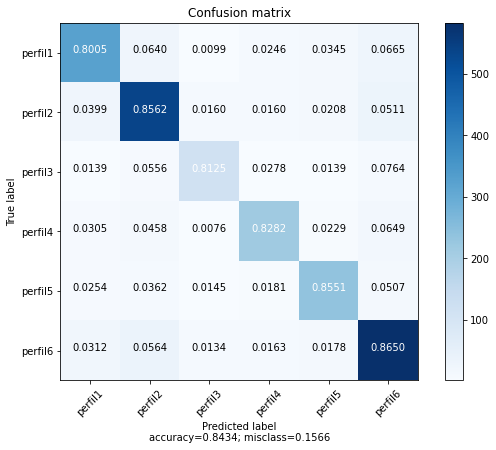

              precision    recall  f1-score   support

     perfil1       0.84      0.80      0.82       406
     perfil2       0.85      0.86      0.85       626
     perfil3       0.80      0.81      0.81       144
     perfil4       0.84      0.83      0.84       262
     perfil5       0.83      0.86      0.84       276
     perfil6       0.85      0.86      0.86       674

    accuracy                           0.84      2388
   macro avg       0.84      0.84      0.84      2388
weighted avg       0.84      0.84      0.84      2388



In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['perfil1', 'perfil2', 'perfil3', 'perfil4', 'perfil5', 'perfil6'])
print(classification_report(y_test, y_pred))

Percebe-se que foram obtidos valores adequados para todos os perfis de alunos do LIT, com os *F1-Score* variando entre 81 e 86% e uma acurácia total de 84%. 

Os maiores erros de classificação ocorrem entre os perfis 1, 2 e 6, como é possível visualizar na matriz de confusão. Para melhorar este modelo, o ideal é buscar características que diferenciem de melhor forma estes três perfis.

<hr>

## Scoring dos dados necessários para entregar a solução

Como entrega da sua solução, esperamos os resultados classificados no seguinte dataset chamado "to_be_scored.csv":

### Download da "folha de respostas"

In [ ]:
import urllib.request
url = 'https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/to_be_scored.csv'
filename = 'to_be_scored.csv'
urllib.request.urlretrieve(url, filename)

df_to_be_scored = pd.read_csv(r'to_be_scored.csv')
df_to_be_scored.tail()

,id,graduacao,universidade,profissao,organizacao,pretende_fazer_cursos_lit,interesse_mba_lit,importante_ter_certificado,horas_semanais_estudo,como_conheceu_lit,total_modulos,modulos_iniciados,modulos_finalizados,certificados
995,741745189,SEM FORMAÇÃO,UNIVERSIDADE NOVE DE JULHO,Coordenador,Borracha,0,0,1,2,YouTube,245,63,45,1
996,996387882,Bacharelado,UFRN,Assessor,Estado,1,1,1,8,Google,163,111,96,0
997,668869418,Bacharelado,UFSCar,Gerente,Siderurgica,1,1,1,9,Facebook,56,10,4,0
998,676531718,Tecnólogo,FATEC,Outros,servicos,1,1,1,9,Mídia (revista/jornal/web),138,60,30,0
999,388402340,Especialização,UNIP,Advogado,Montadora,0,0,1,9,Mídia (revista/jornal/web),22,20,19,0


O dataframe ``to_be_scored`` é a "folha de respostas". A coluna "categoria" não existe nessa amostra.

In [ ]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          1000 non-null   int64 
 1   graduacao                   1000 non-null   object
 2   universidade                1000 non-null   object
 3   profissao                   1000 non-null   object
 4   organizacao                 1000 non-null   object
 5   pretende_fazer_cursos_lit   1000 non-null   int64 
 6   interesse_mba_lit           1000 non-null   int64 
 7   importante_ter_certificado  1000 non-null   int64 
 8   horas_semanais_estudo       1000 non-null   int64 
 9   como_conheceu_lit           1000 non-null   object
 10  total_modulos               1000 non-null   int64 
 11  modulos_iniciados           1000 non-null   int64 
 12  modulos_finalizados         1000 non-null   int64 
 13  certificados                1000 non-null   int64


Para poder aplicar o modelo e classificar a folha de respostas, é preciso primeiro aplicar as mesmas transformações com colunas aplicadas no dataset de treino, menos a remoção de linhas da folha de respostas. Ao final, as 1000 entradas devem estar classificadas, com os valores previstos em uma coluna chamada "target".



Na célula abaixo, repetimos rapidamente os mesmos passos de pré-processamento utilizados no modelo treinado XGBoost.

In [ ]:
# 1 - Remoção de colunas
df_to_be_scored_1 = df_to_be_scored.drop(['id',
               'graduacao',
               'universidade',
               'organizacao',
               'importante_ter_certificado',
               'modulos_iniciados',
               'pretende_fazer_cursos_lit',
               'total_modulos',
               'como_conheceu_lit'], axis=1)

# 2 - Encoding com "dummy variables"
df_to_be_scored_2 = pd.get_dummies(df_to_be_scored_1, columns=['profissao'])
df_to_be_scored_2.tail()

,interesse_mba_lit,horas_semanais_estudo,modulos_finalizados,certificados,profissao_Advogado,profissao_Analista,profissao_Analista Senior,profissao_Assessor,profissao_Coordenador,profissao_Diretor,profissao_Engenheiro,profissao_Gerente,profissao_Outros,profissao_SEM EXPERIÊNCIA,profissao_Supervisor,profissao_Sócio/Dono/Proprietário
995,0,2,45,1,0,0,0,0,1,0,0,0,0,0,0,0
996,1,8,96,0,0,0,0,1,0,0,0,0,0,0,0,0
997,1,9,4,0,0,0,0,0,0,0,0,1,0,0,0,0
998,1,9,30,0,0,0,0,0,0,0,0,0,1,0,0,0
999,0,9,19,0,1,0,0,0,0,0,0,0,0,0,0,0


<hr>

Pode ser verificado abaixo que as colunas da folha de resposta agora são idênticas às que foram usadas para treinar o modelo:

In [ ]:
features.columns

Index(['interesse_mba_lit', 'horas_semanais_estudo', 'modulos_finalizados',
       'certificados', 'profissao_Advogado', 'profissao_Analista',
       'profissao_Analista Senior', 'profissao_Assessor',
       'profissao_Coordenador', 'profissao_Diretor', 'profissao_Engenheiro',
       'profissao_Gerente', 'profissao_Outros', 'profissao_SEM EXPERIÊNCIA',
       'profissao_Supervisor', 'profissao_Sócio/Dono/Proprietário'],
      dtype='object')

In [ ]:
df_to_be_scored_2.columns

Index(['interesse_mba_lit', 'horas_semanais_estudo', 'modulos_finalizados',
       'certificados', 'profissao_Advogado', 'profissao_Analista',
       'profissao_Analista Senior', 'profissao_Assessor',
       'profissao_Coordenador', 'profissao_Diretor', 'profissao_Engenheiro',
       'profissao_Gerente', 'profissao_Outros', 'profissao_SEM EXPERIÊNCIA',
       'profissao_Supervisor', 'profissao_Sócio/Dono/Proprietário'],
      dtype='object')

Fazendo a predição dos perfis de cada aluno, obtêm-se o dataset final com a varíavel ``target`` inclusa.

In [ ]:
y_pred = boost_model.predict(df_to_be_scored_2)
df_to_be_scored_2['target'] = y_pred
df_to_be_scored_2.tail()

,interesse_mba_lit,horas_semanais_estudo,modulos_finalizados,certificados,profissao_Advogado,profissao_Analista,profissao_Analista Senior,profissao_Assessor,profissao_Coordenador,profissao_Diretor,profissao_Engenheiro,profissao_Gerente,profissao_Outros,profissao_SEM EXPERIÊNCIA,profissao_Supervisor,profissao_Sócio/Dono/Proprietário,target
995,0,2,45,1,0,0,0,0,1,0,0,0,0,0,0,0,perfil1
996,1,8,96,0,0,0,0,1,0,0,0,0,0,0,0,0,perfil2
997,1,9,4,0,0,0,0,0,0,0,0,1,0,0,0,0,perfil6
998,1,9,30,0,0,0,0,0,0,0,0,0,1,0,0,0,perfil2
999,0,9,19,0,1,0,0,0,0,0,0,0,0,0,0,0,perfil3


### Salvando a folha de respostas como um arquivo .csv para ser submetido

In [ ]:
df_to_be_scored_2.to_csv('results.csv',index=False)

Pronto, a folha de respostas pode ser submetida para o Desafio 6 da Maratona Behind The Code 2020.